# 03_anchor_generator
**This file used to generate anchors for UECFOOD100 dataset through kmeans.
Distance here is not Euclidean distance but IoU (Intersection over Union) in
accordance with original yolo-v2 paper.**

In [13]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

**k-means clustering**:  
- Input: k, set of points [w1,h1], [w2,h2], [w3, h3], ..., [wn, hn] 
- Place centroids c1, ..., ck at random locations (randomly select k [w,h] among input img wh)
- Repeat until convergence:
    - for each point [wi,hi]:
        - find nearest centroid cj. (np.argmin(new_distances, axis=1))
        - assign the point [wi,hi] to cluster j.
    - for each cluster j=1, ...,k: (update centroids)
        - new centroid cj=mean of all points [wi,hi] assigned to cluster j in previous step
        $\frac{1}{n_j}\sum\limits_{x_i\rightarrow c_j}x_i(a)$  (a means a particular attribute in this case a is wh[i])
- Stop when none of the cluster assignments change

In [14]:
def kmeans(wh, centroids, anchor_txt):
    num = wh.shape[0]  # total number of different wh pairs
    k, dim = centroids.shape
    iter = 0
    old_distances = np.zeros((num, k))
    _assignments = -np.ones(num)

    # iterate until
    while True:
        new_distances = []
        iter += 1
        for i in range(num):
            distance = 1 - IoU(wh[i], centroids)  # high IoU represents low distance
            new_distances.append(distance)
        new_distances = np.array(new_distances)
        print('Iter {}: distances: {}'.format(iter, np.sum((np.abs(old_distances - new_distances)))))

        # for each input img assign a centroid (select the closed one)
        assignments = np.argmin(new_distances, axis=1)
        if (assignments == _assignments).all():
            print('final centroids =', centroids)
            save_anchors(centroids, anchor_txt, wh_in_mobilenet)
            return centroids
        else:
            centroid_sums = np.zeros((k, dim), np.float)
            for i in range(num):
                centroid_sums[assignments[i]] += wh[i]  # sum up attribute
            for j in range(k):
                # new centroids
                centroids[j] = centroid_sums[j] / np.sum(assignments == j)

            _assignments = assignments.copy()
            old_distances = new_distances.copy()

In [15]:
def save_anchors(centroids, anchor_txt, wh_in_mobilenet):
    width_in_yolov2 = wh_in_mobilenet[0]
    height_in_yolov2 = wh_in_mobilenet[1]
    with open(anchor_txt, 'w') as file:
        anchors = centroids.copy()
        for i in range(anchors.shape[0]):
            anchors[i][0] *= width_in_yolov2 / 32.
            anchors[i][1] *= height_in_yolov2 / 32.
        widths = anchors[:, 0]
        sorted_indices = np.argsort(widths)  # return the indices that sort tht array
        print('anchors = ', anchors[sorted_indices])

        for i in sorted_indices:
            file.write('%0.2f, %0.2f\n' % (anchors[i, 0], anchors[i, 1]))

In [16]:
def avgIoU(wh, centroids):
    sum = 0.
    for i in range(wh.shape[0]):
        sum += max(IoU(wh[i], centroids))
    return sum / wh.shape[0]

**IoU - Intersection over Union **

In [17]:
def IoU(whi, centroids):
    """ Calculate IoU between current centroids with one in wh array to check if current
    centroids are suitable enough
    :param whi:
    :param centroids:
    :return:
    """
    IOU = []
    for centroid in centroids:
        c_w, c_h = centroid
        w, h = whi
        if c_w >= w and c_h >= h:
            iou = w * h / (c_w * c_h)
        elif c_w >= w and c_h <= h:
            iou = w * c_h / (w * h + (c_w - w) * c_h)
        elif c_w <= w and c_h >= h:
            iou = c_w * h / (w * h + (c_h - h) * c_w)
        else:
            iou = c_w * c_h / (w * h)
        IOU.append(iou)
    return np.array(IOU)

In [18]:
def coordinate2wh(coordinates, uec100_dims):
    coordinates = list(map(float, coordinates))
    w = (coordinates[2] - coordinates[0]) / uec100_dims[0]  # x2-x1
    h = (coordinates[3] - coordinates[1]) / uec100_dims[0]  # y2-y1
    return w, h

In [19]:
def gen_anchors(n_clusters, uec100_dims):
#     dataset_disk = '/Volumes/JS/UECFOOD100_448/'
    dataset_disk = '/Volumes/JS/UECFOOD256/UECFOOD256/'
    output_path = dataset_disk + 'generated_anchors_mobilenet'
    train_uec100 = dataset_disk + 'train_uec100.txt'

    if not os.path.exists(output_path):
        os.mkdir(output_path)

    wh = []

    with open(train_uec100, 'r') as file:
        for i, line in enumerate(file):
            if i > 0:
                line = line.rstrip('\n')
                line = line.split(' ')
                coordinates = line[2:]
                w, h = coordinate2wh(coordinates, uec100_dims)
                wh.append([w, h])
        wh = np.array(wh)

        if n_clusters == 0:  # make from 1 to 10 clusters and pick the best one
            avgIou = []
            for n_cluster in range(1, 11):
                anchor_txt = os.path.join(output_path, 'anchors_%d.txt' % (n_cluster))
                # randomly select n_cluster anchors from wh array which contain w,h for each img
                indices = [random.randrange(wh.shape[0]) for i in range(n_cluster)]
                centroids = wh[indices]
                centroids = kmeans(wh, centroids, anchor_txt)
                avgIou.append([n_cluster, avgIoU(wh, centroids)])
            avgIou = np.array(avgIou)
            plt.plot(avgIou[:, 0], avgIou[:, 1])
            plt.scatter(avgIou[:, 0], avgIou[:, 1], c='r')
            plt.xlabel('number of cluster')
            plt.ylabel('average IoU')
            plt.savefig('avg_iou')
            plt.show()
        else:
            anchor_txt = os.path.join(output_path, 'anchors_%d.txt' % (n_clusters))
            # randomly select n_cluster anchors from wh array which contain w,h for each img
            indices = [random.randrange(wh.shape[0]) for i in range(n_clusters)]
            centroids = wh[indices]
            kmeans(wh, centroids, anchor_txt)

        print('Done!')

In [20]:
wh_in_mobilenet = [224, 224]
uec256_dims = [800, 600]  # dataset image width=800, height=600
n_clusters = 0

Iter 1: distances: 6439.081953018273
Iter 2: distances: 1502.4241820992652
final centroids = [[0.82967159 0.59879794]]
anchors =  [[5.80770111 4.19158555]]
Iter 1: distances: 13713.249932488576
Iter 2: distances: 7047.968361947456
Iter 3: distances: 952.0684015650139
Iter 4: distances: 286.0811004657852
Iter 5: distances: 124.93331806168813
Iter 6: distances: 58.83405822579511
Iter 7: distances: 40.594084970225545
Iter 8: distances: 33.36535520934179
Iter 9: distances: 14.074751956789118
Iter 10: distances: 5.99299915348872
final centroids = [[0.89020512 0.64055733]
 [0.50504423 0.37485192]]
anchors =  [[3.53530962 2.62396346]
 [6.23143583 4.48390133]]
Iter 1: distances: 17296.5058157133
Iter 2: distances: 4851.76651552535
Iter 3: distances: 3346.801200186473
Iter 4: distances: 2383.0171833477375
Iter 5: distances: 1675.8396475056759
Iter 6: distances: 1341.4134931086974
Iter 7: distances: 1110.6600373770345
Iter 8: distances: 846.592896163226
Iter 9: distances: 727.4165863159917
Iter 

Iter 27: distances: 88.08409313617373
Iter 28: distances: 75.30593829995597
Iter 29: distances: 93.9412878087846
Iter 30: distances: 92.62039307481514
Iter 31: distances: 76.58379324578745
Iter 32: distances: 87.87187983335278
Iter 33: distances: 84.91292134480449
Iter 34: distances: 109.36173582103093
Iter 35: distances: 101.15228347611263
Iter 36: distances: 432.9199863188209
Iter 37: distances: 285.39358497387025
Iter 38: distances: 285.25104754630354
Iter 39: distances: 196.9833646862731
Iter 40: distances: 150.48786003013853
Iter 41: distances: 134.15215636950836
Iter 42: distances: 117.2321233584751
Iter 43: distances: 76.01333454383524
Iter 44: distances: 60.01999823814483
Iter 45: distances: 45.91911484779296
Iter 46: distances: 30.019759140143073
Iter 47: distances: 30.322098236463273
Iter 48: distances: 32.521186553818126
Iter 49: distances: 34.02593695092004
Iter 50: distances: 16.122314162405452
Iter 51: distances: 13.115329290923214
Iter 52: distances: 9.681345564052101
It

Iter 32: distances: 118.90649037172074
Iter 33: distances: 102.4208859447042
Iter 34: distances: 117.32965959113342
Iter 35: distances: 91.33608229816069
Iter 36: distances: 63.97866676140786
Iter 37: distances: 35.68682157970065
Iter 38: distances: 36.067933881288475
Iter 39: distances: 18.2472455679531
Iter 40: distances: 13.364434313592865
Iter 41: distances: 19.063166280427957
Iter 42: distances: 14.68282898716158
Iter 43: distances: 19.52968716082536
Iter 44: distances: 19.595945446301446
Iter 45: distances: 27.77891759238093
Iter 46: distances: 26.586282407566582
Iter 47: distances: 23.135453822431455
Iter 48: distances: 15.188220437172967
Iter 49: distances: 20.939429178209696
Iter 50: distances: 5.72758716694334
Iter 51: distances: 2.848659931140465
Iter 52: distances: 1.293059183740651
final centroids = [[0.79501239 0.35638904]
 [0.96370505 0.70416273]
 [0.93891889 0.52388282]
 [0.87835529 0.65673742]
 [0.2917797  0.23122191]
 [0.42316006 0.37470866]
 [0.69617379 0.66567894]
 

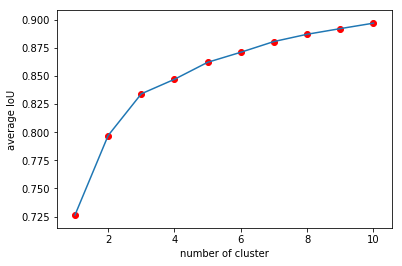

Done!


In [21]:
gen_anchors(n_clusters, uec256_dims)